## 1. Biblioteki

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import os
import talos as ta
from talos.model.early_stopper import early_stopper
from sklearn.preprocessing import StandardScaler

%load_ext tensorboard
import tensorflow_addons as tfa
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.metrics import Recall, Precision
import seaborn as sns

from sklearn.model_selection import train_test_split


import tensorflow as tf

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from tensorflow.keras.callbacks import EarlyStopping
from focal_loss import BinaryFocalLoss

In [2]:
"""
Define our custom loss function.
"""
import numpy as np
from keras import backend as K
import tensorflow as tf



def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed


def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed



## 2. Dane

In [3]:
train_df=pd.read_csv("D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/Dane_do_uczenia_M.csv", encoding="utf-8")
del train_df['Unnamed: 0']

In [4]:
train_df.head()

,ENSG00000212232.1,ENSG00000238741.1,ENSG00000252481.1,ENSG00000239002.3,ENSG00000212443.1,ENSG00000274012.1,ENSG00000252010.1,ENSG00000202198.1,ENSG00000251791.1,ENSG00000202058.1,...,ENSG00000241475.1,ENSG00000274618.1,ENSG00000227293.1,ENSG00000253526.1,ENSG00000270654.1,ENSG00000271394.1,ENSG00000265423.1,ENSG00000253165.1,ENSG00000201901.1,scale
0,27.356617,31.768974,27.356617,5.294829,8.824715,6.645010e+02,2.647415,4.235863e+02,7.059772,16.766959,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
1,8.695633,1.086954,6.521724,2.173908,0.000000,1.758692e+03,1.086954,5.434770e+01,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
2,20.185177,77.002713,7.475992,4.485595,8.971190,2.775836e+03,2.242797,2.609121e+02,6.728392,10.466388,...,0.000000,0.747599,0.0,0.747599,0.0,0.747599,0.000000,0.0,0.000000,M0
3,18.157930,17.431612,6.536855,2.178952,2.905269,2.338741e+02,3.631586,6.827382e+01,1.452634,1.452634,...,0.726317,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,M0
4,29912.168049,21631.677176,9554.333460,20332.131551,5136.495208,1.255850e+06,19221.760289,1.926818e+06,5198.182500,2655.637935,...,0.000000,953.068666,0.0,20.562431,0.0,269.367843,64.771657,0.0,123.374585,M0


In [5]:
train_df['scale'].loc[(train_df['scale'] == 'M0')] = 0
train_df['scale'].loc[(train_df['scale'] == 'M1')] = 1

In [6]:
train_df=train_df.loc[(train_df['scale']!='MX')]

In [7]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['scale'])
#test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42,stratify=test_df['scale'])


train_label=train_df['scale']
test_label=test_df['scale']
#val_label=val_df['scale']
del train_df['scale']
del test_df['scale']
#del val_df['scale']


In [8]:
len(list(train_df))

110

In [9]:
train_label.shape

(568,)

In [10]:
test_label.shape

(142,)

In [11]:
#val_label.shape

## 1.2 Standaryzacja

In [12]:
scaler = StandardScaler()
train_df=scaler.fit_transform(train_df)
test_df=scaler.fit_transform(test_df)
#val_df=scaler.fit_transform(val_df)


In [13]:
train_df

array([[-0.23532639, -0.28536286, -0.29189695, ..., -0.20273415,
        -0.13658188, -0.25716709],
       [-0.23488914, -0.28412701, -0.28766847, ..., -0.20273415,
        -0.13658188, -0.25716709],
       [-0.23513615, -0.28194648, -0.28119849, ..., -0.1127296 ,
        -0.13658188, -0.18291094],
       ...,
       [-0.23560858, -0.28411483, -0.29158105, ..., -0.20273415,
        -0.07110588, -0.25716709],
       [13.92769305,  3.11477926,  6.81130447, ..., -0.05473062,
        -0.13658188,  1.2895196 ],
       [-0.23495945, -0.28021459, -0.28164044, ..., -0.20273415,
        -0.07405669, -0.25716709]])

In [14]:
train_df.shape

(568, 110)

In [15]:
train_label=np.asarray(train_label).astype(np.int)
test_label=np.asarray(test_label).astype(np.int)
#val_label=np.asarray(val_label).astype(np.int)

In [16]:
train_label

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
train_label.shape

(568,)

In [18]:
train_label=train_label.reshape(-1,1)
test_label=test_label.reshape(-1,1)
#val_label=val_label.reshape(-1,1)

In [19]:
test_label.shape

(142, 1)

# 2 Moduł TALOS

## 2.1 Słownik parametrów do wypróbowania

In [20]:
p = {
    'first_neuron':[110,220], 
     'hidden_neuron':[50,100],

     'hidden_layers':[1,3,5],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [16,32],

    'lr':[0.01],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

#    'batc_normalization':[False,True],
#    'dropout': [0,0.2,0.4],
    'dropout': [0],
    
    #'optimizer': ['rmsprop','adam','adadelta','adamax','nadam','adagrad'],
    #'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
    'kernel_initializer': ['orthogonal'],
    #'activation_layer':['sigmoid','tanh','selu','elu','relu'],
    'activation_layer':['relu'],
    #'batc_normalization':[False,True]
    'batc_normalization':[False]
}

In [21]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=1, beta=1.0, threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=0,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

## 2.3 Przeprowadzam skan, używając parametrów i funkcji wyżej


In [22]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - podejscie z Focal-loss (nowe)')

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

  4%|███▍                                                                               | 1/24 [00:05<02:15,  5.89s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

  8%|██████▉                                                                            | 2/24 [00:11<02:06,  5.77s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 12%|██████████▍                                                                        | 3/24 [00:18<02:16,  6.51s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 17%|█████████████▊                                                                     | 4/24 [00:25<02:12,  6.61s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning

 21%|█████████████████▎                                                                 | 5/24 [00:36<02:31,  7.96s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warnin

 25%|████████████████████▊                                                              | 6/24 [00:45<02:29,  8.32s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 29%|████████████████████████▏                                                          | 7/24 [00:50<02:06,  7.44s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 33%|███████████████████████████▋                                                       | 8/24 [00:56<01:51,  6.98s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 38%|███████████████████████████████▏                                                   | 9/24 [01:03<01:44,  6.93s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 42%|██████████████████████████████████▏                                               | 10/24 [01:11<01:41,  7.24s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning

 46%|█████████████████████████████████████▌                                            | 11/24 [01:25<02:01,  9.37s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 16, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 5, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warnin

 50%|█████████████████████████████████████████                                         | 12/24 [01:35<01:53,  9.45s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 54%|████████████████████████████████████████████▍                                     | 13/24 [01:40<01:29,  8.12s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 58%|███████████████████████████████████████████████▊                                  | 14/24 [01:47<01:16,  7.67s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 62%|███████████████████████████████████████████████████▎                              | 15/24 [01:53<01:05,  7.23s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 67%|██████████████████████████████████████████████████████▋                           | 16/24 [01:59<00:55,  6.96s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning

 71%|██████████████████████████████████████████████████████████                        | 17/24 [02:07<00:51,  7.41s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warnin

 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [02:19<00:51,  8.52s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 1, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_n

 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [02:24<00:38,  7.68s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 1, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_

 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [02:30<00:28,  7.05s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 3, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [02:37<00:20,  6.97s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 3, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with 

 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [02:43<00:13,  6.89s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning

 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [02:51<00:07,  7.02s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 220, 'hidden_layers': 5, 'hidden_neuron': 100, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warnin

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [03:01<00:00,  7.55s/it]


In [30]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/M/Predykcja klasy M - podejscie z Focal-loss (nowe)/050522200516.csv')
#binary cross

In [31]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [32]:
nowe_wart

[0.14814815,
 0.07407407,
 0.13793103,
 0.0,
 0.14814815,
 0.0,
 0.0,
 0.14285715,
 0.14814815,
 0.07692307,
 0.0,
 0.0,
 0.14285715,
 0.13793103,
 0.14285715,
 0.0,
 0.16000001,
 0.13793103,
 0.07692307,
 0.07692307,
 0.0,
 0.0,
 0.0,
 0.15384614]

In [33]:
df['val_fbeta_score']=nowe_wart

In [34]:
df=df.sort_values('val_loss',ascending=True)

In [35]:
df.columns

Index(['round_epochs', 'loss', 'fbeta_score', 'precision', 'recall',
       'val_loss', 'val_fbeta_score', 'val_precision', 'val_recall',
       'activation_layer', 'activity_regularizer', 'batc_normalization',
       'batch_size', 'bias_regularizer', 'dropout', 'epochs', 'first_neuron',
       'hidden_layers', 'hidden_neuron', 'kernel_initializer',
       'kernel_regularizer_l1', 'kernel_regularizer_l2', 'last_activation',
       'lr'],
      dtype='object')

In [36]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
16,111,0.393906,[0.17021276],1.000000,0.093023,0.442490,0.160000,0.666667,0.090909,relu,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
23,113,0.404395,[0.13043478],1.000000,0.069767,0.450072,0.153846,0.500000,0.090909,relu,...,0,100000,220,5,100,orthogonal,0.0001,0.0001,sigmoid,0.01
10,143,0.380517,[0.15053762],1.000000,0.081395,0.459007,0.000000,0.000000,0.000000,relu,...,0,100000,220,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
17,137,0.380368,[0.17021276],1.000000,0.093023,0.459688,0.137931,0.285714,0.090909,relu,...,0,100000,110,5,100,orthogonal,0.0001,0.0001,sigmoid,0.01
4,115,0.381882,[0.2268041],1.000000,0.127907,0.461955,0.148148,0.400000,0.090909,relu,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
5,86,0.396855,[0.15053762],1.000000,0.081395,0.469225,0.000000,0.000000,0.000000,relu,...,0,100000,110,5,100,orthogonal,0.0001,0.0001,sigmoid,0.01
22,77,0.395137,[0.17021276],1.000000,0.093023,0.479357,0.000000,0.000000,0.000000,relu,...,0,100000,220,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
1,69,0.382846,[0.17021276],1.000000,0.093023,0.480909,0.074074,0.200000,0.045455,relu,...,0,100000,110,1,100,orthogonal,0.0001,0.0001,sigmoid,0.01
12,70,0.392894,[0.17021276],1.000000,0.093023,0.485268,0.142857,0.333333,0.090909,relu,...,0,100000,110,1,50,orthogonal,0.0001,0.0001,sigmoid,0.01
2,77,0.388409,[0.14893618],0.875000,0.081395,0.488937,0.137931,0.285714,0.090909,relu,...,0,100000,110,3,50,orthogonal,0.0001,0.0001,sigmoid,0.01


In [39]:
df=df[df['val_fbeta_score']!=0]

In [42]:
df['batch_size']

16    32
23    32
17    32
4     16
1     16
12    32
2     16
8     16
19    32
9     16
13    32
7     16
18    32
14    32
0     16
Name: batch_size, dtype: int64

In [37]:
df=df.sort_values('val_loss',ascending=True)

In [38]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr
16,111,0.393906,[0.17021276],1.000000,0.093023,0.442490,0.160000,0.666667,0.090909,relu,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
23,113,0.404395,[0.13043478],1.000000,0.069767,0.450072,0.153846,0.500000,0.090909,relu,...,0,100000,220,5,100,orthogonal,0.0001,0.0001,sigmoid,0.01
10,143,0.380517,[0.15053762],1.000000,0.081395,0.459007,0.000000,0.000000,0.000000,relu,...,0,100000,220,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
17,137,0.380368,[0.17021276],1.000000,0.093023,0.459688,0.137931,0.285714,0.090909,relu,...,0,100000,110,5,100,orthogonal,0.0001,0.0001,sigmoid,0.01
4,115,0.381882,[0.2268041],1.000000,0.127907,0.461955,0.148148,0.400000,0.090909,relu,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
5,86,0.396855,[0.15053762],1.000000,0.081395,0.469225,0.000000,0.000000,0.000000,relu,...,0,100000,110,5,100,orthogonal,0.0001,0.0001,sigmoid,0.01
22,77,0.395137,[0.17021276],1.000000,0.093023,0.479357,0.000000,0.000000,0.000000,relu,...,0,100000,220,5,50,orthogonal,0.0001,0.0001,sigmoid,0.01
1,69,0.382846,[0.17021276],1.000000,0.093023,0.480909,0.074074,0.200000,0.045455,relu,...,0,100000,110,1,100,orthogonal,0.0001,0.0001,sigmoid,0.01
12,70,0.392894,[0.17021276],1.000000,0.093023,0.485268,0.142857,0.333333,0.090909,relu,...,0,100000,110,1,50,orthogonal,0.0001,0.0001,sigmoid,0.01
2,77,0.388409,[0.14893618],0.875000,0.081395,0.488937,0.137931,0.285714,0.090909,relu,...,0,100000,110,3,50,orthogonal,0.0001,0.0001,sigmoid,0.01


In [ ]:
df.iloc[0]

Text(0.5, 1.0, 'Validation Loss as function of first_neuron')

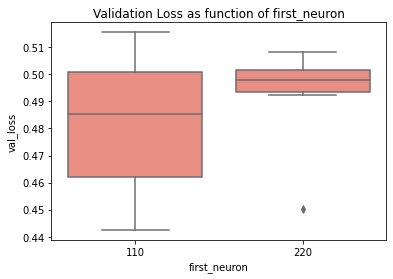

In [50]:
metric = 'first_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of hidden_neuron')

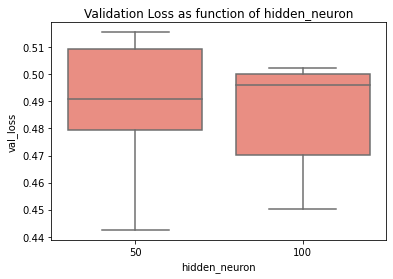

In [51]:
metric = 'hidden_neuron'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of hidden_layers')

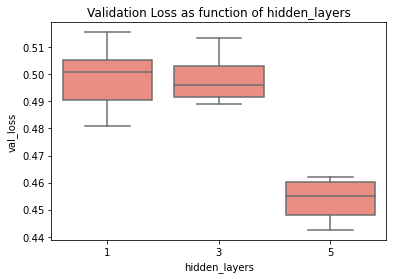

In [43]:
metric = 'hidden_layers'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of kernel_initializer')

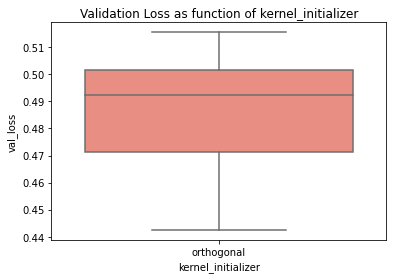

In [44]:
metric = 'kernel_initializer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of activation_layer')

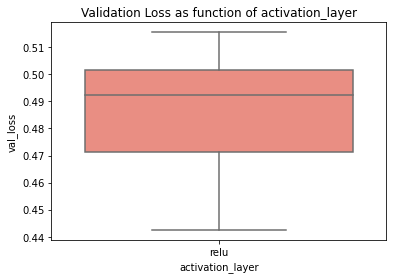

In [45]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of batc_normalization')

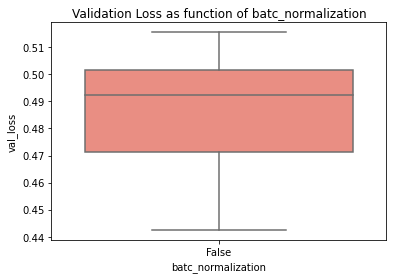

In [46]:
metric = 'batc_normalization'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of dropout')

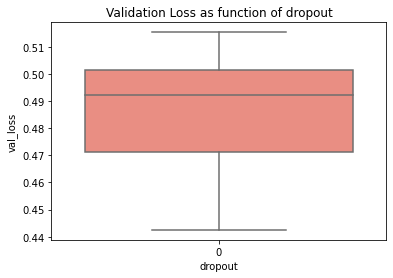

In [47]:
metric = 'dropout'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of batch_size')

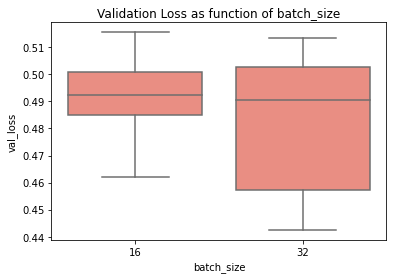

In [49]:
metric = 'batch_size'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


## Part 2

In [59]:
p = {
    'first_neuron':[110],  #
     'hidden_neuron':[50], #

     'hidden_layers':[5,7],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [32], #

    #'lr':[0.01],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

#    'batc_normalization':[False,True],
#    'dropout': [0,0.2,0.4],
    'dropout': [0],
    
    'optimizer': ['rmsprop','adam','adadelta','adamax','nadam','adagrad'],
   # 'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
    'kernel_initializer': ['orthogonal'],
    'activation_layer':['sigmoid','tanh','selu','elu','relu'],
   # 'activation_layer':['relu'],
    #'batc_normalization':[False,True]
    'batc_normalization':[False]
}

In [60]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss="binary_crossentropy",
                  optimizer=params['optimizer'],#tf.keras.optimizers.Adamax(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=1, beta=1.0, threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=0,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [61]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - podejscie z Focal-loss (nowe)')



  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 17%|█████████████▋                                                                    | 2/12 [11:44<58:42, 352.21s/it]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert




  2%|█▍                                                                                 | 1/60 [00:07<07:50,  7.98s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



  3%|██▊                                                                                | 2/60 [00:17<08:50,  9.15s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile



  5%|████▏                                                                              | 3/60 [00:44<16:20, 17.21s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc



  7%|█████▌                                                                             | 4/60 [00:52<12:25, 13.32s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



  8%|██████▉                                                                            | 5/60 [01:00<10:41, 11.66s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen



 10%|████████▎                                                                          | 6/60 [01:08<09:19, 10.36s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no at



 12%|█████████▋                                                                         | 7/60 [01:16<08:22,  9.48s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



 13%|███████████                                                                        | 8/60 [01:26<08:24,  9.70s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no a



 15%|████████████▍                                                                      | 9/60 [01:55<13:17, 15.64s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no att



 17%|█████████████▋                                                                    | 10/60 [02:04<11:29, 13.79s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attr



 18%|███████████████                                                                   | 11/60 [02:15<10:22, 12.71s/it]

{'activation_layer': 'sigmoid', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no at



 20%|████████████████▍                                                                 | 12/60 [02:25<09:33, 11.94s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 22%|█████████████████▊                                                                | 13/60 [02:33<08:23, 10.72s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence thi



 23%|███████████████████▏                                                              | 14/60 [02:40<07:28,  9.76s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 25%|████████████████████▌                                                             | 15/60 [03:11<12:01, 16.03s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 27%|█████████████████████▊                                                            | 16/60 [03:19<10:01, 13.68s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence th



 28%|███████████████████████▏                                                          | 17/60 [03:27<08:31, 11.90s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 30%|████████████████████████▌                                                         | 18/60 [03:34<07:21, 10.51s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



 32%|█████████████████████████▉                                                        | 19/60 [03:41<06:31,  9.55s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribut



 33%|███████████████████████████▎                                                      | 20/60 [03:51<06:22,  9.56s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attr



 35%|████████████████████████████▋                                                     | 21/60 [04:16<09:18, 14.33s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attrib



 37%|██████████████████████████████                                                    | 22/60 [04:26<08:06, 12.80s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribu



 38%|███████████████████████████████▍                                                  | 23/60 [04:37<07:41, 12.47s/it]

{'activation_layer': 'tanh', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



 40%|████████████████████████████████▊                                                 | 24/60 [04:47<06:54, 11.52s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 42%|██████████████████████████████████▏                                               | 25/60 [04:54<05:57, 10.22s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence thi



 43%|███████████████████████████████████▌                                              | 26/60 [05:02<05:24,  9.55s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 45%|████████████████████████████████████▉                                             | 27/60 [05:30<08:17, 15.06s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 47%|██████████████████████████████████████▎                                           | 28/60 [05:38<06:59, 13.10s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence th



 48%|███████████████████████████████████████▋                                          | 29/60 [05:47<06:02, 11.69s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 50%|█████████████████████████████████████████                                         | 30/60 [05:54<05:10, 10.37s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



 52%|██████████████████████████████████████████▎                                       | 31/60 [06:03<04:52, 10.08s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribut



 53%|███████████████████████████████████████████▋                                      | 32/60 [06:15<04:56, 10.60s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attr



 55%|█████████████████████████████████████████████                                     | 33/60 [06:50<08:01, 17.82s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attrib



 57%|██████████████████████████████████████████████▍                                   | 34/60 [06:59<06:34, 15.18s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribu



 58%|███████████████████████████████████████████████▊                                  | 35/60 [07:10<05:50, 14.03s/it]

{'activation_layer': 'selu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



 60%|█████████████████████████████████████████████████▏                                | 36/60 [07:18<04:53, 12.25s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 62%|██████████████████████████████████████████████████▌                               | 37/60 [07:27<04:16, 11.15s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this



 63%|███████████████████████████████████████████████████▉                              | 38/60 [07:36<03:54, 10.65s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 65%|█████████████████████████████████████████████████████▎                            | 39/60 [08:02<05:20, 15.26s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence th



 67%|██████████████████████████████████████████████████████▋                           | 40/60 [08:12<04:29, 13.46s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence thi



 68%|████████████████████████████████████████████████████████                          | 41/60 [08:19<03:41, 11.68s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [08:30<03:23, 11.31s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attrib



 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [08:41<03:10, 11.20s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute



 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [08:49<02:48, 10.52s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [09:19<04:04, 16.32s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribu



 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [09:29<03:20, 14.31s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribut



 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [09:38<02:46, 12.81s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attrib



 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [09:48<02:20, 11.75s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [09:55<01:54, 10.43s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence thi



 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [10:04<01:38,  9.90s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence



 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [10:29<02:12, 14.70s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence t



 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [10:36<01:38, 12.30s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence th



 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [10:46<01:20, 11.48s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence 



 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [10:54<01:02, 10.45s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [11:03<00:50, 10.20s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribut



 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [11:14<00:41, 10.40s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attr



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [11:40<00:44, 14.89s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attrib



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [11:50<00:27, 13.57s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribu



 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [12:02<00:13, 13.20s/it]

{'activation_layer': 'relu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attri



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [12:13<00:00, 12.22s/it]


In [62]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/M/Predykcja klasy M - podejscie z Focal-loss (nowe)/050522202709.csv')
#binary cross

In [64]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [65]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,optimizer
0,100,0.408327,[0.24761903],0.684211,0.151163,0.472344,[0.22222222],0.600000,0.136364,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,rmsprop
1,157,0.389283,[0.1875],0.900000,0.104651,0.469775,[0.19354838],0.333333,0.136364,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,adam
2,573,0.719981,[0.],0.000000,0.000000,0.723887,[0.],0.000000,0.000000,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,adadelta
3,107,0.458733,[0.25742576],0.866667,0.151163,0.603184,[0.14285715],0.333333,0.090909,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,adamax
4,115,0.400272,[0.25490195],0.812500,0.151163,0.535720,[0.13793103],0.285714,0.090909,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,nadam
5,120,0.702675,[0.],0.000000,0.000000,0.711571,[0.],0.000000,0.000000,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,adagrad
6,88,0.414603,[0.17021276],1.000000,0.093023,0.510673,[0.],0.000000,0.000000,sigmoid,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,rmsprop
7,144,0.380351,[0.2990654],0.761905,0.186047,0.476183,[0.20000002],0.375000,0.136364,sigmoid,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,adam
8,559,0.786715,[0.],0.000000,0.000000,0.795366,[0.],0.000000,0.000000,sigmoid,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,adadelta
9,141,0.460638,[0.27450982],0.875000,0.162791,0.630301,[0.],0.000000,0.000000,sigmoid,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,adamax


In [66]:
df['val_fbeta_score']=nowe_wart

In [67]:

df=df.sort_values('val_loss',ascending=True)

In [68]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,optimizer
54,123,0.403238,[0.24489796],1.000000,0.139535,0.463431,0.000000,0.000000,0.000000,relu,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,rmsprop
19,134,0.394937,[0.24242425],0.923077,0.139535,0.466762,0.206897,0.428571,0.136364,tanh,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,adam
1,157,0.389283,[0.1875],0.900000,0.104651,0.469775,0.193548,0.333333,0.136364,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,adam
30,116,0.409646,[0.24000001],0.857143,0.139535,0.471433,0.153846,0.500000,0.090909,selu,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,rmsprop
0,100,0.408327,[0.24761903],0.684211,0.151163,0.472344,0.222222,0.600000,0.136364,sigmoid,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,rmsprop
7,144,0.380351,[0.2990654],0.761905,0.186047,0.476183,0.200000,0.375000,0.136364,sigmoid,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,adam
34,138,0.398233,[0.25742576],0.866667,0.151163,0.483211,0.153846,0.500000,0.090909,selu,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,nadam
55,153,0.391120,[0.29126212],0.882353,0.174419,0.487714,0.160000,0.666667,0.090909,relu,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,adam
24,87,0.407696,[0.185567],0.818182,0.104651,0.489857,0.153846,0.500000,0.090909,selu,...,0,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,rmsprop
42,154,0.399942,[0.24489796],1.000000,0.139535,0.491227,0.076923,0.250000,0.045455,elu,...,0,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,rmsprop


Text(0.5, 1.0, 'Validation Loss as function of optimizer')

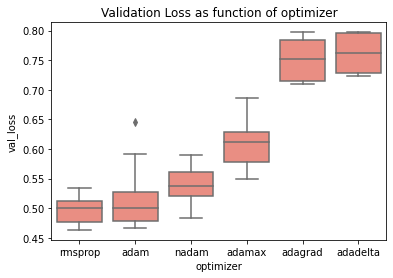

In [69]:
metric = 'optimizer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


Text(0.5, 1.0, 'Validation Loss as function of activation_layer')

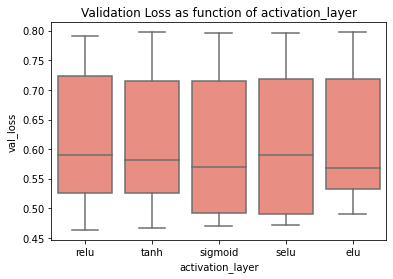

In [70]:
metric = 'activation_layer'
ax = sns.boxplot(x=metric, y="val_loss", data=df.reset_index(),color='salmon')
ax.set_title(f'Validation Loss as function of {metric}')


## Part 3

In [76]:
p = {
    'first_neuron':[110],  #
     'hidden_neuron':[50], #

     'hidden_layers':[5,7],  

     
    'epochs': [100000], # never touch it


    'last_activation': ['sigmoid'], #never touch it


    'batch_size': [32], #

    'lr':[0.01,0.001,0.0001],
    
    'kernel_regularizer_l1':[0.0001],#[0,0.001,0.0001],
    'kernel_regularizer_l2':[0.0001],#[0,0.001,0.0001],
    'bias_regularizer':[0.0001],#[0,0.001,0.0001],
    'activity_regularizer':[0.0001],#[0,0.001,0.0001],

    'dropout': [0],
    
    'optimizer': ['rmsprop','adam','adadelta','adamax','nadam','adagrad'],
    'kernel_initializer': ['orthogonal','identity','zeros','ones','uniform'],
    'activation_layer':['elu'],
#    'batc_normalization':[False,True]
    'batc_normalization':[False]
}

In [77]:

def numerai_model(x_train, y_train, x_val, y_val, params):
    
    print(params)

    model = Sequential()
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation='relu',
               
                    kernel_initializer = params['kernel_initializer'],
                    kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    if params['batc_normalization']==True:
        model.add(BatchNormalization())
        
    if params['dropout']!=0:
        model.add(Dropout(params['dropout']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'], activation='relu',
                    kernel_initializer=params['kernel_initializer'],
                        kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                                    l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                       ))
        if params['batc_normalization']==True:
            model.add(BatchNormalization())
            
        if params['dropout']!=0:
            model.add(Dropout(params['dropout']))
    
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer'],
                   kernel_regularizer=keras.regularizers.l1_l2(l1=params['kernel_regularizer_l1'],
                                                               l2=params['kernel_regularizer_l2']),
                    bias_regularizer=keras.regularizers.l2(params['bias_regularizer']),
                    activity_regularizer=keras.regularizers.l2(params['activity_regularizer'])
                   ))
    
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=params['lr']),
                  metrics=[tfa.metrics.FBetaScore(num_classes=1, beta=1.0, threshold=0.5),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0,
                        callbacks = [
                                     EarlyStopping(monitor='val_loss',
                                        min_delta=0.01,
                                        patience=50, mode='min',verbose=0,
                                                      restore_best_weights=True)
                                    ] #,ta.live(),
                        )

    return history, model

In [78]:

t = ta.Scan(x=train_df, y=train_label,
            x_val=test_df, y_val=test_label,
            model=numerai_model,
            params=p,  
            experiment_name='Predykcja klasy M - podejscie z Focal-loss (nowe)')


  0%|                                                                                          | 0/180 [00:00<?, ?it/s]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


  0%|                                                                                         | 0/1080 [00:57<?, ?it/s]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



  1%|▍                                                                                 | 1/180 [00:07<23:18,  7.81s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


  1%|▉                                                                                 | 2/180 [00:13<19:59,  6.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'


  2%|█▎                                                                                | 3/180 [00:19<18:40,  6.33s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


  2%|█▊                                                                                | 4/180 [00:25<17:50,  6.08s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


  3%|██▎                                                                               | 5/180 [00:30<17:13,  5.90s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'



  3%|██▋                                                                               | 6/180 [00:36<17:09,  5.92s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'


  4%|███▏                                                                              | 7/180 [00:45<19:50,  6.88s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


  4%|███▋                                                                              | 8/180 [00:52<19:26,  6.78s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs


  5%|████                                                                              | 9/180 [00:59<19:43,  6.92s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'



  6%|████▌                                                                            | 10/180 [01:08<21:05,  7.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


  6%|████▉                                                                            | 11/180 [01:14<20:08,  7.15s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'


  7%|█████▍                                                                           | 12/180 [01:21<19:29,  6.96s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs


  7%|█████▊                                                                           | 13/180 [01:31<22:35,  8.11s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


  8%|██████▎                                                                          | 14/180 [01:42<24:16,  8.77s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyarg


  8%|██████▊                                                                          | 15/180 [01:53<26:13,  9.54s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'


  9%|███████▏                                                                         | 16/180 [02:03<26:38,  9.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'



  9%|███████▋                                                                         | 17/180 [02:15<28:04, 10.33s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs


 10%|████████                                                                         | 18/180 [02:27<29:04, 10.77s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 11%|████████▌                                                                        | 19/180 [02:33<25:00,  9.32s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 11%|█████████                                                                        | 20/180 [02:39<22:21,  8.39s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


 12%|█████████▍                                                                       | 21/180 [02:45<20:43,  7.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 12%|█████████▉                                                                       | 22/180 [02:52<19:28,  7.40s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 13%|██████████▎                                                                      | 23/180 [02:58<18:29,  7.07s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 13%|██████████▊                                                                      | 24/180 [03:04<17:37,  6.78s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


 14%|███████████▎                                                                     | 25/180 [03:11<17:10,  6.65s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 14%|███████████▋                                                                     | 26/180 [03:17<16:39,  6.49s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'



 15%|████████████▏                                                                    | 27/180 [03:24<17:09,  6.73s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 16%|████████████▌                                                                    | 28/180 [03:31<17:26,  6.89s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 16%|█████████████                                                                    | 29/180 [03:38<17:11,  6.83s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


 17%|█████████████▌                                                                   | 30/180 [03:45<16:57,  6.78s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'



 17%|█████████████▉                                                                   | 31/180 [03:52<17:13,  6.94s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 18%|██████████████▍                                                                  | 32/180 [03:59<17:11,  6.97s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'


 18%|██████████████▊                                                                  | 33/180 [04:06<17:21,  7.09s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


 19%|███████████████▎                                                                 | 34/180 [04:13<17:11,  7.06s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 19%|███████████████▊                                                                 | 35/180 [04:20<16:56,  7.01s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'



 20%|████████████████▏                                                                | 36/180 [04:27<16:59,  7.08s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 21%|████████████████▋                                                                | 37/180 [04:33<15:54,  6.67s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen


 21%|█████████████████                                                                | 38/180 [04:39<15:06,  6.38s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 22%|█████████████████▌                                                               | 39/180 [04:45<14:31,  6.18s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 22%|██████████████████                                                               | 40/180 [04:50<14:06,  6.04s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile


 23%|██████████████████▍                                                              | 41/180 [04:56<13:48,  5.96s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 23%|██████████████████▉                                                              | 42/180 [05:02<13:33,  5.89s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 24%|███████████████████▎                                                             | 43/180 [05:12<16:05,  7.05s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile


 24%|███████████████████▊                                                             | 44/180 [05:21<17:33,  7.75s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 25%|████████████████████▎                                                            | 45/180 [05:30<18:26,  8.19s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 26%|████████████████████▋                                                            | 46/180 [05:39<19:04,  8.54s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 26%|█████████████████████▏                                                           | 47/180 [05:49<19:36,  8.84s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 27%|█████████████████████▌                                                           | 48/180 [05:59<19:53,  9.04s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 27%|██████████████████████                                                           | 49/180 [06:29<33:57, 15.55s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 28%|██████████████████████▌                                                          | 50/180 [06:59<43:04, 19.88s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 28%|██████████████████████▉                                                          | 51/180 [07:30<49:26, 23.00s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 29%|███████████████████████▍                                                         | 52/180 [08:00<53:31, 25.09s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 29%|███████████████████████▊                                                         | 53/180 [08:30<56:14, 26.57s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 30%|████████████████████████▎                                                        | 54/180 [09:00<58:00, 27.62s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 31%|████████████████████████▊                                                        | 55/180 [09:08<45:29, 21.84s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silenc


 31%|█████████████████████████▏                                                       | 56/180 [09:16<36:39, 17.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 32%|█████████████████████████▋                                                       | 57/180 [09:24<30:24, 14.83s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile


 32%|██████████████████████████                                                       | 58/180 [09:32<26:02, 12.81s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen


 33%|██████████████████████████▌                                                      | 59/180 [09:40<23:03, 11.43s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 33%|███████████████████████████                                                      | 60/180 [09:49<20:52, 10.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 34%|███████████████████████████▍                                                     | 61/180 [10:03<22:47, 11.49s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silen


 34%|███████████████████████████▉                                                     | 62/180 [10:17<24:26, 12.43s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 35%|████████████████████████████▎                                                    | 63/180 [10:31<25:14, 12.94s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 36%|████████████████████████████▊                                                    | 64/180 [10:45<25:27, 13.17s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile


 36%|█████████████████████████████▎                                                   | 65/180 [10:59<25:53, 13.51s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 37%|█████████████████████████████▋                                                   | 66/180 [11:13<25:43, 13.54s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 37%|██████████████████████████████▏                                                  | 67/180 [12:17<53:50, 28.59s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile


 38%|█████████████████████████████▊                                                 | 68/180 [13:19<1:12:23, 38.78s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 38%|██████████████████████████████▎                                                | 69/180 [14:23<1:25:26, 46.18s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 39%|██████████████████████████████▋                                                | 70/180 [15:23<1:32:27, 50.43s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 39%|███████████████████████████████▏                                               | 71/180 [16:25<1:37:46, 53.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 40%|███████████████████████████████▌                                               | 72/180 [17:26<1:41:05, 56.16s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 41%|████████████████████████████████                                               | 73/180 [17:32<1:12:59, 40.93s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sil


 41%|█████████████████████████████████▎                                               | 74/180 [17:37<53:32, 30.31s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 42%|█████████████████████████████████▊                                               | 75/180 [17:43<40:05, 22.91s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 42%|██████████████████████████████████▏                                              | 76/180 [17:49<30:43, 17.73s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 43%|██████████████████████████████████▋                                              | 77/180 [17:55<24:23, 14.21s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 43%|███████████████████████████████████                                              | 78/180 [18:01<19:57, 11.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 44%|███████████████████████████████████▌                                             | 79/180 [18:07<16:52, 10.02s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To si


 44%|████████████████████████████████████                                             | 80/180 [18:12<14:27,  8.67s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


 45%|████████████████████████████████████▍                                            | 81/180 [18:18<12:44,  7.72s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 46%|████████████████████████████████████▉                                            | 82/180 [18:23<11:31,  7.06s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 46%|█████████████████████████████████████▎                                           | 83/180 [18:29<10:41,  6.62s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 47%|█████████████████████████████████████▊                                           | 84/180 [18:35<10:16,  6.42s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


 47%|██████████████████████████████████████▎                                          | 85/180 [18:42<10:48,  6.82s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To s


 48%|██████████████████████████████████████▋                                          | 86/180 [18:49<10:48,  6.90s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'



 48%|███████████████████████████████████████▏                                         | 87/180 [18:57<11:00,  7.10s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To


 49%|███████████████████████████████████████▌                                         | 88/180 [19:04<10:53,  7.10s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To 


 49%|████████████████████████████████████████                                         | 89/180 [19:13<11:40,  7.69s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 5, 'hidden_neuron': 50, 'kernel_initializer': 'uniform', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T


 50%|████████████████████████████████████████▌                                        | 90/180 [19:21<11:24,  7.60s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h


 51%|████████████████████████████████████████▉                                        | 91/180 [19:27<10:54,  7.36s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has 


 51%|█████████████████████████████████████████▍                                       | 92/180 [19:35<10:55,  7.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 


 52%|█████████████████████████████████████████▊                                       | 93/180 [19:42<10:40,  7.37s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 52%|██████████████████████████████████████████▎                                      | 94/180 [19:49<10:07,  7.06s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has


 53%|██████████████████████████████████████████▊                                      | 95/180 [19:55<09:45,  6.89s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h


 53%|███████████████████████████████████████████▏                                     | 96/180 [20:02<09:30,  6.79s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 


 54%|███████████████████████████████████████████▋                                     | 97/180 [20:11<10:24,  7.52s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has


 54%|████████████████████████████████████████████                                     | 98/180 [20:20<10:46,  7.89s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object


 55%|████████████████████████████████████████████▌                                    | 99/180 [20:30<11:42,  8.67s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h


 56%|████████████████████████████████████████████▍                                   | 100/180 [20:39<11:40,  8.76s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 56%|████████████████████████████████████████████▉                                   | 101/180 [20:48<11:35,  8.80s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 


 57%|█████████████████████████████████████████████▎                                  | 102/180 [20:57<11:29,  8.84s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object


 57%|█████████████████████████████████████████████▊                                  | 103/180 [21:11<13:22, 10.42s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 58%|██████████████████████████████████████████████▏                                 | 104/180 [21:23<13:58, 11.03s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' objec


 58%|██████████████████████████████████████████████▋                                 | 105/180 [21:37<14:50, 11.87s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 


 59%|███████████████████████████████████████████████                                 | 106/180 [21:51<15:23, 12.48s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h


 59%|███████████████████████████████████████████████▌                                | 107/180 [22:04<15:25, 12.67s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'orthogonal', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object


 60%|████████████████████████████████████████████████                                | 108/180 [22:18<15:34, 12.98s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has


 61%|████████████████████████████████████████████████▍                               | 109/180 [22:26<13:29, 11.40s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no


 61%|████████████████████████████████████████████████▉                               | 110/180 [22:32<11:40, 10.01s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 62%|█████████████████████████████████████████████████▎                              | 111/180 [22:40<10:31,  9.15s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has 


 62%|█████████████████████████████████████████████████▊                              | 112/180 [22:47<09:36,  8.48s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n


 63%|██████████████████████████████████████████████████▏                             | 113/180 [22:53<08:55,  7.99s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has


 63%|██████████████████████████████████████████████████▋                             | 114/180 [23:01<08:30,  7.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 64%|███████████████████████████████████████████████████                             | 115/180 [23:08<08:12,  7.58s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n


 64%|███████████████████████████████████████████████████▌                            | 116/180 [23:15<08:06,  7.61s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h


 65%|████████████████████████████████████████████████████                            | 117/180 [23:23<07:55,  7.54s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has


 66%|████████████████████████████████████████████████████▍                           | 118/180 [23:30<07:41,  7.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has 


 66%|████████████████████████████████████████████████████▉                           | 119/180 [23:38<07:45,  7.62s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 67%|█████████████████████████████████████████████████████▎                          | 120/180 [23:46<07:44,  7.74s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h


 67%|█████████████████████████████████████████████████████▊                          | 121/180 [23:57<08:25,  8.57s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has 


 68%|██████████████████████████████████████████████████████▏                         | 122/180 [24:06<08:38,  8.94s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object 


 68%|██████████████████████████████████████████████████████▋                         | 123/180 [24:15<08:23,  8.84s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object ha


 69%|███████████████████████████████████████████████████████                         | 124/180 [24:25<08:27,  9.07s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has


 69%|███████████████████████████████████████████████████████▌                        | 125/180 [24:34<08:21,  9.12s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'identity', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object h


 70%|████████████████████████████████████████████████████████                        | 126/180 [24:44<08:36,  9.57s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no


 71%|████████████████████████████████████████████████████████▍                       | 127/180 [24:52<07:53,  8.93s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no at


 71%|████████████████████████████████████████████████████████▉                       | 128/180 [24:59<07:19,  8.46s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n


 72%|█████████████████████████████████████████████████████████▎                      | 129/180 [25:06<06:51,  8.06s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no 


 72%|█████████████████████████████████████████████████████████▊                      | 130/180 [25:14<06:33,  7.87s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no a


 73%|██████████████████████████████████████████████████████████▏                     | 131/180 [25:21<06:13,  7.62s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no


 73%|██████████████████████████████████████████████████████████▋                     | 132/180 [25:28<05:57,  7.44s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n


 74%|███████████████████████████████████████████████████████████                     | 133/180 [25:39<06:39,  8.49s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no a


 74%|███████████████████████████████████████████████████████████▌                    | 134/180 [25:50<07:05,  9.25s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has 


 75%|████████████████████████████████████████████████████████████                    | 135/180 [26:01<07:19,  9.76s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no


 76%|████████████████████████████████████████████████████████████▍                   | 136/180 [26:12<07:24, 10.10s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no 


 76%|████████████████████████████████████████████████████████████▉                   | 137/180 [26:22<07:23, 10.32s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n


 77%|█████████████████████████████████████████████████████████████▎                  | 138/180 [26:33<07:22, 10.52s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has 


 77%|█████████████████████████████████████████████████████████████▊                  | 139/180 [27:08<12:09, 17.79s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no 


 78%|██████████████████████████████████████████████████████████████▏                 | 140/180 [27:43<15:20, 23.02s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adadelta'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has


 78%|██████████████████████████████████████████████████████████████▋                 | 141/180 [28:19<17:21, 26.70s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adamax'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has n


 79%|███████████████████████████████████████████████████████████████                 | 142/180 [28:54<18:27, 29.15s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'nadam'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no


 79%|███████████████████████████████████████████████████████████████▌                | 143/180 [29:26<18:34, 30.13s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'zeros', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.0001, 'optimizer': 'adagrad'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has 


 80%|████████████████████████████████████████████████████████████████                | 144/180 [29:57<18:14, 30.41s/it]

{'activation_layer': 'elu', 'activity_regularizer': 0.0001, 'batc_normalization': False, 'batch_size': 32, 'bias_regularizer': 0.0001, 'dropout': 0, 'epochs': 100000, 'first_neuron': 110, 'hidden_layers': 7, 'hidden_neuron': 50, 'kernel_initializer': 'ones', 'kernel_regularizer_l1': 0.0001, 'kernel_regularizer_l2': 0.0001, 'last_activation': 'sigmoid', 'lr': 0.01, 'optimizer': 'rmsprop'}
adding layer 1
adding layer 2
adding layer 3
adding layer 4
adding layer 5
adding layer 6
adding layer 7
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


InvalidArgumentError:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential/dense_8/Sigmoid:0) = ] [[-nan][-nan][-nan]...] [y (Cast_5/x:0) = ] [0]
	 [[node assert_greater_equal/Assert/AssertGuard/Assert
 (defined at D:\anaconda\lib\site-packages\keras\utils\metrics_utils.py:611)
]] [Op:__inference_train_function_10525500]

Errors may have originated from an input operation.
Input Source operations connected to node assert_greater_equal/Assert/AssertGuard/Assert:
In[0] assert_greater_equal/Assert/AssertGuard/Assert/assert_greater_equal/All:	
In[1] assert_greater_equal/Assert/AssertGuard/Assert/data_0:	
In[2] assert_greater_equal/Assert/AssertGuard/Assert/data_1:	
In[3] assert_greater_equal/Assert/AssertGuard/Assert/data_2:	
In[4] assert_greater_equal/Assert/AssertGuard/Assert/sequential/dense_8/Sigmoid:	
In[5] assert_greater_equal/Assert/AssertGuard/Assert/data_4:	
In[6] assert_greater_equal/Assert/AssertGuard/Assert/Cast_5/x:

Operation defined at: (most recent call last)
>>>   File "D:\anaconda\lib\runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "D:\anaconda\lib\runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "D:\anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "D:\anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "D:\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "D:\anaconda\lib\asyncio\base_events.py", line 541, in run_forever
>>>     self._run_once()
>>> 
>>>   File "D:\anaconda\lib\asyncio\base_events.py", line 1786, in _run_once
>>>     handle._run()
>>> 
>>>   File "D:\anaconda\lib\asyncio\events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "D:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "D:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "D:\anaconda\lib\site-packages\ipykernel\kernelbase.py", line 545, in execute_request
>>>     user_expressions, allow_stdin,
>>> 
>>>   File "D:\anaconda\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "D:\anaconda\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "D:\anaconda\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in run_cell
>>>     raw_cell, store_history, silent, shell_futures)
>>> 
>>>   File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "D:\anaconda\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3166, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-78-e7bdfdb9da50>", line 5, in <module>
>>>     experiment_name='Predykcja klasy M - podejscie z Focal-loss (nowe)')
>>> 
>>>   File "D:\anaconda\lib\site-packages\talos\scan\Scan.py", line 196, in __init__
>>>     scan_run(self)
>>> 
>>>   File "D:\anaconda\lib\site-packages\talos\scan\scan_run.py", line 26, in scan_run
>>>     self = scan_round(self)
>>> 
>>>   File "D:\anaconda\lib\site-packages\talos\scan\scan_round.py", line 19, in scan_round
>>>     self.model_history, self.round_model = ingest_model(self)
>>> 
>>>   File "D:\anaconda\lib\site-packages\talos\model\ingest_model.py", line 10, in ingest_model
>>>     self.round_params)
>>> 
>>>   File "<ipython-input-77-e3294614e259>", line 64, in numerai_model
>>>     restore_best_weights=True)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\engine\training.py", line 817, in train_step
>>>     self.compiled_metrics.update_state(y, y_pred, sample_weight)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\engine\compile_utils.py", line 460, in update_state
>>>     metric_obj.update_state(y_t, y_p, sample_weight=mask)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\utils\metrics_utils.py", line 73, in decorated
>>>     update_op = update_state_fn(*args, **kwargs)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\metrics.py", line 177, in update_state_fn
>>>     return ag_update_state(*args, **kwargs)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\metrics.py", line 1410, in update_state
>>>     sample_weight=sample_weight)
>>> 
>>>   File "D:\anaconda\lib\site-packages\keras\utils\metrics_utils.py", line 611, in update_confusion_matrix_variables
>>>     message='predictions must be >= 0'),
>>> 

Function call stack:
train_function -> assert_greater_equal_Assert_AssertGuard_false_10525259


In [79]:
df = pd.read_csv('D:/STUDIA/ROK_II/Magisterka/Modele/Dane pierwotne/M/Predykcja klasy M - podejscie z Focal-loss (nowe)/050522205253.csv')
#binary cross

In [80]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr,optimizer
0,98,0.428949,[0.],0.0,0.0,0.473674,[0.],0.0,0.0,elu,...,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.0100,rmsprop
1,59,0.426787,[0.],0.0,0.0,0.445202,[0.],0.0,0.0,elu,...,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.0100,adam
2,58,0.428306,[0.],0.0,0.0,0.464828,[0.],0.0,0.0,elu,...,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.0100,adadelta
3,58,0.431504,[0.],0.0,0.0,0.451393,[0.],0.0,0.0,elu,...,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.0100,adamax
4,57,0.423689,[0.],0.0,0.0,0.459189,[0.],0.0,0.0,elu,...,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.0100,nadam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,584,0.464915,[0.],0.0,0.0,0.468334,[0.],0.0,0.0,elu,...,100000,110,7,50,zeros,0.0001,0.0001,sigmoid,0.0001,adam
140,584,0.464928,[0.],0.0,0.0,0.468348,[0.],0.0,0.0,elu,...,100000,110,7,50,zeros,0.0001,0.0001,sigmoid,0.0001,adadelta
141,582,0.465191,[0.],0.0,0.0,0.468601,[0.],0.0,0.0,elu,...,100000,110,7,50,zeros,0.0001,0.0001,sigmoid,0.0001,adamax
142,584,0.464846,[0.],0.0,0.0,0.468264,[0.],0.0,0.0,elu,...,100000,110,7,50,zeros,0.0001,0.0001,sigmoid,0.0001,nadam


In [81]:
stare_wart=df['val_fbeta_score']
nowe_wart=[]
for x in stare_wart:
    wart=x.replace('[','')
    wart=wart.replace(']','')
    wart=float(wart)
    nowe_wart.append(wart)

In [82]:
df['val_fbeta_score']=nowe_wart

In [83]:
df=df.sort_values('val_loss',ascending=True)

In [84]:
df

,round_epochs,loss,fbeta_score,precision,recall,val_loss,val_fbeta_score,val_precision,val_recall,activation_layer,...,epochs,first_neuron,hidden_layers,hidden_neuron,kernel_initializer,kernel_regularizer_l1,kernel_regularizer_l2,last_activation,lr,optimizer
41,59,0.425842,[0.],0.0,0.000000,0.431468,0.000000,0.000000,0.000000,elu,...,100000,110,5,50,zeros,0.0001,0.0001,sigmoid,0.0100,adagrad
126,59,0.425605,[0.],0.0,0.000000,0.431472,0.000000,0.000000,0.000000,elu,...,100000,110,7,50,zeros,0.0001,0.0001,sigmoid,0.0100,rmsprop
128,59,0.425672,[0.],0.0,0.000000,0.431479,0.000000,0.000000,0.000000,elu,...,100000,110,7,50,zeros,0.0001,0.0001,sigmoid,0.0100,adadelta
39,59,0.425684,[0.],0.0,0.000000,0.431491,0.000000,0.000000,0.000000,elu,...,100000,110,5,50,zeros,0.0001,0.0001,sigmoid,0.0100,adamax
40,59,0.425741,[0.],0.0,0.000000,0.431499,0.000000,0.000000,0.000000,elu,...,100000,110,5,50,zeros,0.0001,0.0001,sigmoid,0.0100,nadam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,207,0.479393,[0.17021276],1.0,0.093023,0.581842,0.000000,0.000000,0.000000,elu,...,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,0.0001,adagrad
15,164,0.492485,[0.1875],0.9,0.104651,0.582664,0.142857,0.333333,0.090909,elu,...,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.0001,adamax
13,166,0.495091,[0.17021276],1.0,0.093023,0.593480,0.076923,0.250000,0.045455,elu,...,100000,110,5,50,orthogonal,0.0001,0.0001,sigmoid,0.0001,adam
103,185,0.487273,[0.17021276],1.0,0.093023,0.607072,0.153846,0.500000,0.090909,elu,...,100000,110,7,50,orthogonal,0.0001,0.0001,sigmoid,0.0001,adam
